## **การวิเคราะห์พื้นที่ให้บริการของสถานีรถไฟฟ้า ในเขตจตุจักร กรุงเทพมหานคร**

**1. นำเข้าข้อมูล**

In [23]:
!pip install geopandas
!pip install osmnx

In [24]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [25]:
bts = gpd.read_file("/content/BTS_Station.shp")
mrt = gpd.read_file("/content/MRT_Station.shp")
district = gpd.read_file("/content/Chatuchak.shp")

bts = bts.to_crs(epsg=32647)
mrt = mrt.to_crs(epsg=32647)
district = district.to_crs(epsg=32647)

In [26]:
print("BTS CRS:", bts.crs)
print("MRT CRS:", mrt.crs)
print("District CRS:", district.crs)

BTS CRS: EPSG:32647
MRT CRS: EPSG:32647
District CRS: EPSG:32647


In [27]:
stations = bts._append(mrt, ignore_index=True)

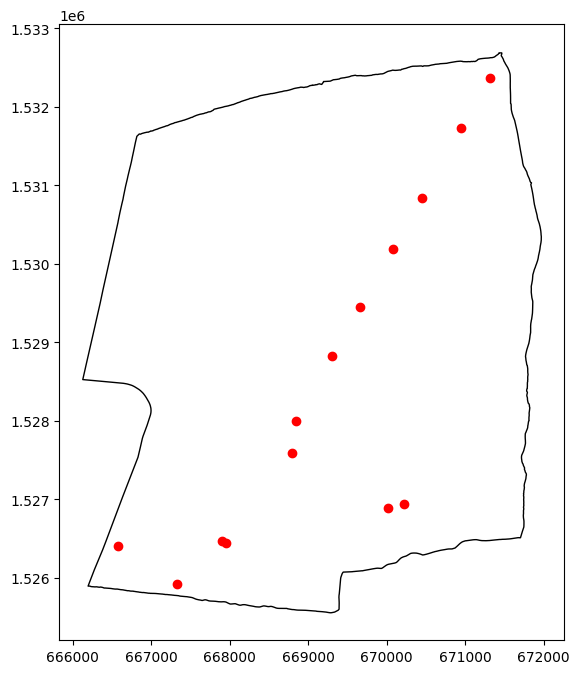

In [28]:
ax = district.plot(color="white", edgecolor="black", figsize=(8,8))
stations.plot(ax=ax, color="red")
plt.show()

**2. กำหนดระยะ Buffer**

In [29]:
stations["buffer"] = stations.geometry.buffer(1000)
buffers = stations.set_geometry("buffer")

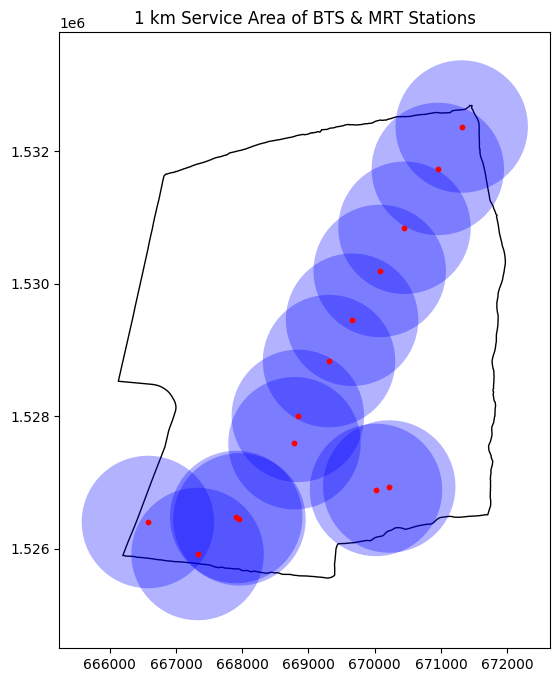

In [30]:
ax = district.plot(color="white", edgecolor="black", figsize=(8,8))
buffers.plot(ax=ax, color="blue", alpha=0.3)
stations.plot(ax=ax, color="red", markersize=10)

plt.title("1 km Service Area of BTS & MRT Stations")
plt.show()

**3. ทำ Spatial Join**

In [31]:
import geopandas as gpd
joined = gpd.sjoin(stations, district, how="inner", predicate="within")

In [32]:
print("Number of stations in district:", len(joined))
for station in joined["name"]:
    print(station)

Number of stations in district: 14
สถานีหมอชิต
สถานีห้าแยกลาดพร้าว
สถานีพหลโยธิน 24
สถานีรัชโยธิน
สถานีมหาวิทยาลัยเกษตรศาสตร์
สถานีเสนานิคม
สถานีบางบัว
สถานีกรมป่าไม้
สถานีบางซื่อ
สถานีสวนจตุจักร
สถานีลาดพร้าว
สถานีกำแพงเพชร
สถานีพหลโยธิน
สถานีลาดพร้าว


**4. คำนวณพื้นที่ครอบคลุม**

In [33]:
buffer_union = buffers.dissolve()
affected_area = gpd.overlay(district, buffer_union, how="intersection")
# พื้นที่เขตทั้งหมด
district_area = district.area.iloc[0]

# พื้นที่ที่ถูกครอบคลุม
covered_area = affected_area.area.iloc[0]


In [34]:
district_km2 = district_area / 1_000_000
covered_km2 = covered_area / 1_000_000

In [35]:
percentage = (covered_area / district_area) * 100

In [36]:
print(f"Total district area: {district_km2:.2f} sq.km")
print(f"Covered area by 5 km buffer: {covered_km2:.2f} sq.km")
print(f"Coverage percentage: {percentage:.2f}%")

Total district area: 32.66 sq.km
Covered area by 5 km buffer: 17.65 sq.km
Coverage percentage: 54.04%


**5. แสดงผลแบบ Interactive Map**

In [37]:
!pip install folium

import folium
import geopandas as gpd

In [38]:
# รวม buffer ทั้งหมด
buffer_union = buffers.unary_union

# สร้าง GeoDataFrame ใหม่
buffer_union_gdf = gpd.GeoDataFrame(
    geometry=[buffer_union],
    crs=buffers.crs
)

/tmp/ipython-input-4031596385.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_union = buffers.unary_union


In [39]:
center_point = district.geometry.centroid.iloc[0]

# แปลง centroid เป็น EPSG:4326
center_point = gpd.GeoSeries(
    [center_point], crs=district.crs
).to_crs(epsg=4326)

center = [
    center_point.geometry.y.iloc[0],
    center_point.geometry.x.iloc[0]
]

# สร้างแผนที่
m = folium.Map(
    location=center,
    zoom_start=13,
    tiles="cartodbpositron"
)


In [40]:
district_4326 = district.to_crs(epsg=4326)
stations_4326 = stations.to_crs(epsg=4326)
buffer_union_4326 = buffer_union_gdf.to_crs(epsg=4326)


In [41]:
folium.GeoJson(
    district_4326,
    name="District Boundary",
    style_function=lambda feature: {
        "fillColor": "none",
        "color": "black",
        "weight": 2,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["dname"],
        aliases=["District:"]
    )
).add_to(m)


In [42]:
folium.GeoJson(
    buffer_union_4326,
    name="5 km Service Area",
    style_function=lambda feature: {
        "fillColor": "blue",
        "color": "blue",
        "weight": 2,
        "fillOpacity": 0.3,
    },
    tooltip="5 km Service Area"
).add_to(m)


In [43]:
for _, row in stations_4326.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=row["name"],
        tooltip=row["name"],
        icon=folium.Icon(color="red", icon="train", prefix="fa")
    ).add_to(m)


In [45]:
folium.LayerControl().add_to(m)
m


## **ความแตกต่างระหว่าง Spatial Join และ Attribute Join**

*   **Spatial Join** คือการเชื่อมข้อมูลโดยอาศัยความสัมพันธ์เชิงพื้นที่ของ geometry เช่น within , contains , intersects
เช่น นับจำนวนสถานีที่อยู่ภายในเขตจตุจักร

* **Attribute Join** คือการเชื่อมข้อมูลโดยใช้ค่าคอลัมน์ที่เหมือนกัน เช่น รหัสของพื้นที่ ไม่ได้พิจารณาตำแหน่งทางภูมิศาสตร์



## **ทำไมเราต้องแปลงระบบพิกัดก่อนใช้ buffer() ใน GeoPandas?**

เพราะ buffer() คำนวณระยะทางตามหน่วยของ CRS ถ้าใช้ EPSG:4326 หน่วยจะเป็นองศา จะทำให้ buffer มีขนาดผิดพลาด จึงต้องแปลงเป็น CRS (เช่น EPSG:32647) ที่มีหน่วยเป็นเมตรก่อน เพื่อให้ buffer ระยะ 5,000 เมตร ถูกต้องจริง

##**หากต้องการวิเคราะห์ระยะ 10 กิโลเมตร แทน 5 กิโลเมตร**
ให้แก้ที่ขั้นตอนสร้าง buffer

จากเดิม

buffers = stations.buffer(5000)


เปลี่ยนเป็น

buffers = stations.buffer(10000)


เพราะ 10 กิโลเมตร = 10,000 เมตร

## **วิธีที่เหมาะสมที่สุดในการแสดงผล Interactive Map**


วิธีที่เหมาะสมที่สุดในการแสดงผล Interactive Map คืออะไร เพราะเหตุใด?

การใช้ Folium เหมาะสมที่สุด เพราะ

* รองรับ Interactive Map

* สามารถ zoom, pan, เปิด-ปิด layer ได้

* แสดง popup และ tooltip ได้

* แปลง GeoDataFrame เป็น GeoJSON ได้โดยตรง

ทำให้ผู้ใช้งานสามารถสำรวจข้อมูลเชิงพื้นที่ได้สะดวกและเข้าใจง่าย




## **หาก Buffer มีขนาดไม่ถูกต้อง อาจเกิดจากอะไร และแก้ไขอย่างไร**
สาเหตุที่เป็นไปได้

* ใช้ CRS แบบ Geographic

* ไม่ได้แปลง CRS ก่อน buffer

* ใช้หน่วยผิด (เช่น ใส่ 5 แทน 5000)

* CRS ของ layer ไม่ตรงกัน

วิธีแก้

* ตรวจสอบ CRS
* แปลงเป็น Projected CRS ก่อน buffer
* ใช้หน่วยเป็นเมตร (เช่น 5000 = 5 km)